In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import timm

class OrganoidSeg(nn.Module):
    def __init__(self, num_classes=2, img_size=224, patch_size=16, model_name='vit_base_patch16_224'):
        super().__init__()
        
        # Hyperparamètres dérivés du modèle ViT de base (vit_base_patch16_224)
        self.patch_size = patch_size
        embed_dim = 768 # Dimension de l'embedding pour ViT Base
        
        # 1. ENCODEUR (Backbone ViT/DINOv2)
        # On charge le modèle ViT/DINO sans la tête de classification, et on garde les tokens.
        # global_pool=' ' : Désactive l'agrégation finale (CLS token ou Mean)
        # pour obtenir tous les tokens spatiaux.
        self.encoder = timm.create_model(
            model_name, 
            pretrained=True, 
            num_classes=0,
            global_pool='', # Important : conserve les tokens spatiaux
            img_size=img_size
        )
        
        # Geler l'entraînement du corps du modèle (le 'backbone')
        for param in self.encoder.parameters():
            param.requires_grad = False

        # 2. DÉCODEUR (Tête de Segmentation)
        # La sortie du ViT est une séquence de tokens (non spatiale).
        # Pour la segmentation, nous devons la remodeler et l'upsampler.
        
        # L'encodeur produit (Batch_size, Num_tokens, embed_dim).
        # Pour une image 224x224 avec des patchs de 16x16: Num_tokens = (224/16)^2 = 196
        
        # 2a. Projection de chaque token vers le nombre de classes (ex: 2)
        self.projection_head = nn.Linear(embed_dim, num_classes)
        
        # 2b. Upsampling (suréchantillonnage) pour restaurer la résolution 224x224
        # On utilise le 'bilinear' pour l'interpolation pour la qualité,
        # sans avoir besoin de ConvTranspose2d complexes pour ce simple exemple.
        self.upsample = nn.Upsample(scale_factor=patch_size, mode='bilinear', align_corners=False)
    def forward(self, xb):
        # 1. ENCODEUR : Récupérer tous les tokens (B, 257, 768)
        tokens = self.encoder.forward_features(xb) 
        
        # *** CORRECTION APPLIQUÉE ICI ***
        # 2. RETIRER le CLS Token (le premier token) 
        # Le slicing [:, 1:] sélectionne tous les éléments sauf le premier de la deuxième dimension
        # Le tenseur devient (B, 256, 768)
        tokens_spatial = tokens[:, 1:] 
        
        # 3. PROJECTION : Appliquer la tête de classification aux tokens spatiaux
        # Sortie : (B, 256, 1)
        logits_flat = self.projection_head(tokens_spatial)
        
        # 4. REMODELAGE : Reconstruire la carte spatiale (16x16)
        # N vaut maintenant 256
        B, N, C = logits_flat.shape
        H_low = W_low = int(N**0.5) # 16
        
        # Sortie : (B, 1, 16, 16)
        logits_spatial = logits_flat.transpose(1, 2).reshape(B, C, H_low, W_low) 
        
        # 5. UPSAMPLING : Restaurer la résolution finale (518x518 ou ce qui est configuré)
        output_mask = self.upsample(logits_spatial)
        
        return output_mask
    

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DiceLoss(nn.Module):
    """
    Calcule le coefficient de Dice et retourne la Dice Loss (1 - Dice).
    Utilise la Sigmoid pour les logits du modèle.
    """
    def __init__(self, smooth=1e-6):
        super(DiceLoss, self).__init__()
        # Le 'smooth' est un petit terme pour éviter la division par zéro.
        self.smooth = smooth

    def forward(self, pred, target):
        # 1. Conversion des Logits en Probabilités pour la segmentation binaire
        pred = torch.sigmoid(pred) 
        
        # 2. Aplatissement des Tenseurs (conserver uniquement les dimensions des pixels)
        pred_flat = pred.view(-1)
        target_flat = target.view(-1)

        # 3. Calcul de l'Intersection (produit) et de l'Union (somme)
        intersection = (pred_flat * target_flat).sum()
        
        # Formule du coefficient de Dice
        dice_coefficient = (2. * intersection + self.smooth) / (pred_flat.sum() + target_flat.sum() + self.smooth)
        
        # 4. Calcul de la Loss
        dice_loss = 1.0 - dice_coefficient
        
        return dice_loss
    
class CombinedLoss(nn.Module):
    """
    Combinaison de la Binary Cross-Entropy (BCE) Loss et de la Dice Loss.
    La BCE est utilisée avec logits pour une meilleure stabilité (BCEWithLogitsLoss).
    """
    def __init__(self, dice_weight=0.5):
        super(CombinedLoss, self).__init__()
        
        # BCEWithLogitsLoss est la BCE combinée avec Sigmoid pour une meilleure stabilité numérique.
        self.bce = nn.BCEWithLogitsLoss()
        self.dice = DiceLoss()
        
        self.dice_weight = dice_weight
        self.bce_weight = 1.0 - dice_weight # Poids complémentaire

    def forward(self, pred_logits, target_mask):
        """
        :param pred_logits: Sortie du modèle (logits).
        :param target_mask: Masque de vérité terrain (0.0 ou 1.0).
        """
        
        # 1. Calcul de la BCE Loss (utilise les logits, car elle contient déjà la Sigmoid)
        bce_loss = self.bce(pred_logits, target_mask)
        
        # 2. Calcul de la Dice Loss (utilise aussi les logits, la Sigmoid est interne à DiceLoss)
        dice_loss = self.dice(pred_logits, target_mask)
        
        # 3. Combinaison pondérée des deux pertes
        total_loss = (self.bce_weight * bce_loss) + (self.dice_weight * dice_loss)
        
        return total_loss

In [4]:
import torch
import torch.nn.functional as F
import numpy as np # Pour la moyenne des métriques

class DiceCoefficientMetric(object):
    """
    Calcule le Dice Coefficient (Score F1) pour la segmentation binaire.
    """
    def __init__(self, smooth=1e-6):
        self.smooth = smooth

    def __call__(self, pred_logits, target_mask):
        # 1. Conversion des Logits en Probabilités
        # La Sigmoid transforme les logits du modèle en valeurs entre 0 et 1 (probabilités).
        pred = torch.sigmoid(pred_logits) 
        
        # 2. Aplatissement des Tenseurs
        pred_flat = pred.view(-1)
        target_flat = target_mask.view(-1)

        # 3. Calcul de l'Intersection et de l'Union
        intersection = (pred_flat * target_flat).sum()
        
        # Formule du coefficient de Dice
        dice_coefficient = (2. * intersection + self.smooth) / (pred_flat.sum() + target_flat.sum() + self.smooth)
        
        return dice_coefficient

In [5]:
import torch
from torch.utils.data import Dataset
import torchvision.transforms as T
from pycocotools.coco import COCO
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt # Importé pour le test

class OrganoidSegDataset(Dataset):
    def __init__(self, data_dir, json_file, img_size=224, target_category_ids=None):
        super().__init__() 
        self.data_dir = data_dir
        self.coco = COCO(json_file)
        self.ids = list(self.coco.imgs.keys())
        self.img_size = img_size
        self.target_category_ids = target_category_ids
        
        # Transformations pour l'Image (ToTensor et Normalisation)
        self.image_transform = T.Compose([
            T.ToTensor(), 
            T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
            
        # Transformation pour le Redimensionnement de l'Image
        self.resize = T.Resize((img_size, img_size))
        
        # Transformation pour le Redimensionnement du MASQUE (Interpolation NEAREST obligatoire)
        self.resize_mask = T.Resize(
            (img_size, img_size), 
            interpolation=T.InterpolationMode.NEAREST
        )

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        img_id = self.ids[idx]
        img_info = self.coco.loadImgs(img_id)[0]
        file_name = img_info['file_name']
        
        # 1. Chargement de l'Image
        img_path = os.path.join(self.data_dir, file_name)
        
        try:
             image = Image.open(img_path).convert('RGB')
        except FileNotFoundError:
             raise FileNotFoundError(f"❌ Erreur: Fichier image introuvable à {img_path}. Vérifiez votre DATA_DIR.")

        # *** CORRECTION MAJEURE ***
        # Utiliser la taille réelle de l'image chargée (le patch 512x512) 
        # pour créer le masque, car les Bboxes sont relatives à ce patch.
        mask_h, mask_w = image.height, image.width # Ex: 512, 512

        # Redimensionnement de l'image à la taille finale (224x224)
        image = self.resize(image)
        
        # 2. Création du Masque Global (Ground Truth)
        ann_ids = self.coco.getAnnIds(imgIds=img_id)
        anns = self.coco.loadAnns(ann_ids)
        
        # Le masque est créé à la taille réelle du patch (ex: 512x512)
        mask = np.zeros((mask_h, mask_w), dtype=np.uint8)
        
        for ann in anns:
            # Filtrage par catégorie
            if self.target_category_ids is not None and ann['category_id'] not in self.target_category_ids:
                continue

            mask_instance = None
            
            # --- Tente d'utiliser la vraie Segmentation ---
            if 'segmentation' in ann and ann['segmentation'] is not None and len(ann['segmentation']) > 0:
                try:
                    mask_instance = self.coco.annToMask(ann)
                except Exception:
                    # Ignore les annotations mal formatées et tente Bbox
                    pass
            
            # --- Utilise la Bounding Box si Segmentation est absente ou échoue ---
            if mask_instance is None and 'bbox' in ann:
                # Extrait les coordonnées : [x, y, width, height]
                [x, y, w, h] = [int(val) for val in ann['bbox']]
                
                # Crée un masque rectangulaire à la taille du patch (mask_h x mask_w)
                mask_instance = np.zeros((mask_h, mask_w), dtype=np.uint8)
                
                # Calcule les bornes dans l'espace du patch
                x_min = max(0, x)
                y_min = max(0, y)
                x_max = min(mask_w, x + w)
                y_max = min(mask_h, y + h)
                
                # Remplissage du rectangle avec des 1
                if x_max > x_min and y_max > y_min:
                    mask_instance[y_min:y_max, x_min:x_max] = 1
                else:
                    mask_instance = None # Annotation invalide
            
            # Si un masque d'instance a été créé, on le combine au masque global
            if mask_instance is not None:
                mask = np.maximum(mask, mask_instance * 1) 

        # 3. Finalisation des Tensors
        image_tensor = self.image_transform(image)
        mask = torch.as_tensor(mask, dtype=torch.uint8)
        
        # Le masque est redimensionné correctement du patch (512x512) à 224x224
        mask = self.resize_mask(mask.unsqueeze(0)) 
        mask_tensor = mask.float()

        # Retourne les Tensors
        return image_tensor, mask_tensor

--- Démarrage du test pour multiorg_mmdet_coco/train.json ---
loading annotations into memory...
Done (t=0.25s)
creating index...
index created!
✅ Longueur du Dataset: 20011 images trouvées.
✅ Chargement de l'élément 5531 réussi.
✅ Formes des Tensors correctes. Image: torch.Size([3, 224, 224]), Masque: torch.Size([1, 224, 224])
✅ Annotation trouvée: 837.0 pixels annotés pour l'organoïde.


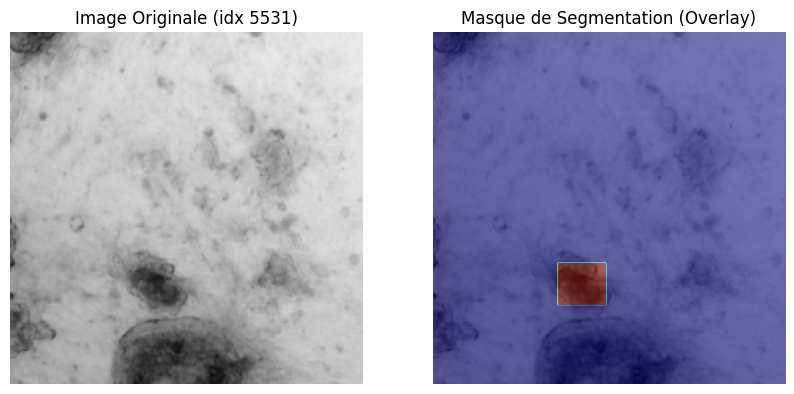

In [6]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from random import randint

# Assurez-vous que la classe OrganoidSegDataset est définie ici ou importée.
# ... (votre code de la classe OrganoidSegDataset ici) ...

def test_dataset_loading(data_dir, json_file, sample_index=0):
    """
    Vérifie le chargement des données, la forme des tenseurs et visualise l'image et le masque.
    
    :param data_dir: Chemin vers le dossier des images (ex: 'multiorg_mmdet_coco/train').
    :param json_file: Chemin vers le fichier COCO.
    :param sample_index: Index de l'élément à tester (par défaut le premier).
    """
    
    print(f"--- Démarrage du test pour {json_file} ---")
    
    try:
        # Instanciation de la classe Dataset
        dataset = OrganoidSegDataset(data_dir=data_dir, json_file=json_file)
        
        # 1. Vérification de la Longueur
        data_length = len(dataset)
        assert data_length > 0, "Le Dataset est vide. Vérifiez le chemin du JSON et son contenu."
        print(f"✅ Longueur du Dataset: {data_length} images trouvées.")
        
        # 2. Chargement d'un élément
        image_tensor, mask_tensor = dataset[sample_index]
        print(f"✅ Chargement de l'élément {sample_index} réussi.")

        # 3. Vérification des Formes
        
        # Forme de l'Image (3 canaux, H, W)
        assert image_tensor.shape == torch.Size([3, dataset.img_size, dataset.img_size]), \
            f"❌ Erreur de forme de l'Image. Attendue: (3, {dataset.img_size}, {dataset.img_size}), Obtenue: {image_tensor.shape}"
        
        # Forme du Masque (1 canal, H, W)
        assert mask_tensor.shape == torch.Size([1, dataset.img_size, dataset.img_size]), \
            f"❌ Erreur de forme du Masque. Attendue: (1, {dataset.img_size}, {dataset.img_size}), Obtenue: {mask_tensor.shape}"

        print(f"✅ Formes des Tensors correctes. Image: {image_tensor.shape}, Masque: {mask_tensor.shape}")
        
        # 4. Vérification de l'Annotation (le masque n'est pas vide)
        
        # Convertir le masque en NumPy pour vérifier la somme des pixels
        mask_np = mask_tensor.squeeze(0).numpy() # Retirer la dimension du canal (1, H, W) -> (H, W)
        total_annotated_pixels = np.sum(mask_np)
        
        # Si le masque est non nul, cela signifie qu'il y a des organoïdes annotés.
        # Attention: pour un cas général, nous pourrions avoir une image sans organoïde.
        # Ici, nous vérifions si l'implémentation a généré des masques.
        if total_annotated_pixels > 0:
            print(f"✅ Annotation trouvée: {total_annotated_pixels} pixels annotés pour l'organoïde.")
        else:
            print("⚠️ Attention: Masque d'annotation vide pour cet échantillon. (Cela peut être normal si l'image ne contient pas d'organoïde)")

        # 5. Visualisation (La preuve visuelle)
        
        # Pour visualiser, il faut dénormaliser l'image
        mean = np.array([0.485, 0.456, 0.406]).reshape(3, 1, 1)
        std = np.array([0.229, 0.224, 0.225]).reshape(3, 1, 1)
        
        image_np = image_tensor.numpy() * std + mean
        image_np = np.clip(image_np, 0, 1)
        image_np = image_np.transpose((1, 2, 0)) # De (C, H, W) à (H, W, C) pour Matplotlib
        
        plt.figure(figsize=(10, 5))
        
        plt.subplot(1, 2, 1)
        plt.imshow(image_np)
        plt.title(f"Image Originale (idx {sample_index})")
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(image_np)
        # Afficher le masque par-dessus l'image
        # Nous utilisons 'alpha=0.5' pour la transparence et un colormap pour la couleur
        plt.imshow(mask_np, cmap='jet', alpha=0.5) 
        plt.title("Masque de Segmentation (Overlay)")
        plt.axis('off')
        
        plt.show()

    except Exception as e:
        print(f"❌ Une erreur est survenue pendant le test: {e}")

# --- UTILISATION ---
# Remplacez ces chemins par les chemins réels de vos fichiers
DATA_FOLDER = 'multiorg_mmdet_coco/train'
JSON_PATH = 'multiorg_mmdet_coco/train.json'

# # Lancez le test sur le premier élément
n=randint(0,20000)
test_dataset_loading(data_dir=DATA_FOLDER, json_file=JSON_PATH,sample_index=n)

In [ ]:
from torch.utils.data import DataLoader, Subset
import torch.optim as optim
import time
from torch.utils.data import DataLoader
from tqdm import tqdm # Pour les barres de progression
import random

DEVICE = torch.device("cpu")

# --- Configuration des Chemins ---

# Le dossier parent contenant 'train' et 'val'
BASE_DIR = 'multiorg_mmdet_coco/' 
# Le dossier des images d'entraînement (doit exister)
TRAIN_DATA_FOLDER = BASE_DIR + 'train'
# Le fichier JSON d'entraînement
TRAIN_JSON_PATH = BASE_DIR + 'train.json'
# Le dossier des images de validation (doit exister)
VAL_DATA_FOLDER = BASE_DIR + 'val' 
# Le fichier JSON de validation
VAL_JSON_PATH = BASE_DIR + 'val.json'


# Hyperparamètres d'entraînement
LEARNING_RATE = 1e-4
NUM_EPOCHS = 10
BATCH_SIZE = 1
IMG_SIZE = 224
NUM_SAMPLES_TRAIN_TEST = 20     # Nombre total d'images à utiliser pour l'entraînement (pour essai rapide)
NUM_SAMPLES_VAL_TEST = 10       # Nombre total d'images à utiliser pour la validation (pour essai rapide)

# --- Initialisation des Composants ---

# 2. Chargement des Datasets et Création des Sous-Ensembles

full_train_dataset = OrganoidSegDataset(data_dir=TRAIN_DATA_FOLDER, json_file=TRAIN_JSON_PATH, img_size=IMG_SIZE)
full_val_dataset = OrganoidSegDataset(data_dir=VAL_DATA_FOLDER, json_file=VAL_JSON_PATH, img_size=IMG_SIZE)

# Création du sous-ensemble d'ENTRAINEMENT
train_indices = random.sample(
    range(len(full_train_dataset)), 
    min(len(full_train_dataset), NUM_SAMPLES_TRAIN_TEST) # Utilise le minimum entre la taille demandée et la taille réelle
)
train_subset = Subset(full_train_dataset, train_indices)

# Création du sous-ensemble de VALIDATION
val_indices = random.sample(
    range(len(full_val_dataset)), 
    min(len(full_val_dataset), NUM_SAMPLES_VAL_TEST)
)
val_subset = Subset(full_val_dataset, val_indices)

print(f"Dataset d'Entraînement utilisé: {len(train_subset)} images.")
print(f"Dataset de Validation utilisé: {len(val_subset)} images.")

# Création des DataLoaders
# Utilise BATCH_SIZE et les subsets réduits
train_dataloader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_dataloader = DataLoader(val_subset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

# 2. Modèle
model = OrganoidSeg(num_classes=1).to(DEVICE)

# 3. Fonction de Perte
criterion = CombinedLoss(dice_weight=0.5).to(DEVICE)

# 4. Optimiseur
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)


loading annotations into memory...
Done (t=0.24s)
creating index...
index created!
loading annotations into memory...
Done (t=0.03s)
creating index...
index created!
Dataset d'Entraînement utilisé: 20 images.
Dataset de Validation utilisé: 10 images.


In [8]:
from tqdm import tqdm
import torch.optim as optim

# Initialiser le calculateur de métrique (pour évaluer le Dice Score)
dice_metric_fn = DiceCoefficientMetric()

def train_validate_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs):
    
    history = {'train_loss': [], 'val_loss': [], 'val_dice': []}
    
    for epoch in range(num_epochs):
        model.train() # Mode Entraînement
        current_train_loss = 0.0
        
        # --- PHASE D'ENTRAÎNEMENT (Train) ---
        print(f"\n--- Époque {epoch+1}/{num_epochs} : Entraînement ---")
        
        # tqdm(train_loader, ...) affiche une barre de progression
        for data, targets in tqdm(train_loader, desc=f"Epoch {epoch+1} (Train)"):
            data = data.to(device)
            targets = targets.to(device)

            predictions = model(data)
            loss = criterion(predictions, targets)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            current_train_loss += loss.item() * data.size(0)
            
        avg_train_loss = current_train_loss / len(train_loader.dataset)
        history['train_loss'].append(avg_train_loss)

        # --- PHASE DE VALIDATION (Val) ---
        model.eval() # Mode Évaluation (désactive dropout, etc.)
        current_val_loss = 0.0
        current_val_dice = 0.0
        
        print(f"--- Époque {epoch+1}/{num_epochs} : Validation ---")
        with torch.no_grad():
            for data, targets in tqdm(val_loader, desc=f"Epoch {epoch+1} (Val)"):
                data = data.to(device)
                targets = targets.to(device)
                
                predictions = model(data)
                
                # Calcul de la Loss et du Dice Score
                loss = criterion(predictions, targets)
                dice_score = dice_metric_fn(predictions, targets)
                
                current_val_loss += loss.item() * data.size(0)
                current_val_dice += dice_score.item() * data.size(0)

        avg_val_loss = current_val_loss / len(val_loader.dataset)
        avg_val_dice = current_val_dice / len(val_loader.dataset)
        
        history['val_loss'].append(avg_val_loss)
        history['val_dice'].append(avg_val_dice)

        # --- Affichage des Résultats de l'Époque ---
        print("\n" + "="*80)
        print(f"Époque [{epoch+1}/{num_epochs}] :")
        print(f"  Train Loss: {avg_train_loss:.6f}")
        print(f"  Validation Loss: {avg_val_loss:.6f} | Validation Dice Score: {avg_val_dice:.4f}")
        print("="*80)
        
    return history


--- Époque 1/10 : Entraînement ---


Epoch 1 (Train): 100%|██████████| 5/5 [00:06<00:00,  1.37s/it]


--- Époque 1/10 : Validation ---


Epoch 1 (Val): 100%|██████████| 3/3 [00:03<00:00,  1.13s/it]



Époque [1/10] :
  Train Loss: 0.774087
  Validation Loss: 0.772869 | Validation Dice Score: 0.0434

--- Époque 2/10 : Entraînement ---


Epoch 2 (Train): 100%|██████████| 5/5 [00:07<00:00,  1.50s/it]


--- Époque 2/10 : Validation ---


Epoch 2 (Val): 100%|██████████| 3/3 [00:03<00:00,  1.22s/it]



Époque [2/10] :
  Train Loss: 0.715768
  Validation Loss: 0.717487 | Validation Dice Score: 0.0429

--- Époque 3/10 : Entraînement ---


Epoch 3 (Train): 100%|██████████| 5/5 [00:07<00:00,  1.48s/it]


--- Époque 3/10 : Validation ---


Epoch 3 (Val): 100%|██████████| 3/3 [00:03<00:00,  1.17s/it]



Époque [3/10] :
  Train Loss: 0.673650
  Validation Loss: 0.675825 | Validation Dice Score: 0.0425

--- Époque 4/10 : Entraînement ---


Epoch 4 (Train): 100%|██████████| 5/5 [00:07<00:00,  1.56s/it]


--- Époque 4/10 : Validation ---


Epoch 4 (Val): 100%|██████████| 3/3 [00:03<00:00,  1.21s/it]



Époque [4/10] :
  Train Loss: 0.641457
  Validation Loss: 0.643458 | Validation Dice Score: 0.0418

--- Époque 5/10 : Entraînement ---


Epoch 5 (Train): 100%|██████████| 5/5 [00:07<00:00,  1.45s/it]


--- Époque 5/10 : Validation ---


Epoch 5 (Val): 100%|██████████| 3/3 [00:03<00:00,  1.33s/it]



Époque [5/10] :
  Train Loss: 0.623193
  Validation Loss: 0.620035 | Validation Dice Score: 0.0415

--- Époque 6/10 : Entraînement ---


Epoch 6 (Train): 100%|██████████| 5/5 [00:07<00:00,  1.59s/it]


--- Époque 6/10 : Validation ---


Epoch 6 (Val): 100%|██████████| 3/3 [00:03<00:00,  1.33s/it]



Époque [6/10] :
  Train Loss: 0.602524
  Validation Loss: 0.603510 | Validation Dice Score: 0.0416

--- Époque 7/10 : Entraînement ---


Epoch 7 (Train): 100%|██████████| 5/5 [00:07<00:00,  1.52s/it]


--- Époque 7/10 : Validation ---


Epoch 7 (Val): 100%|██████████| 3/3 [00:03<00:00,  1.23s/it]



Époque [7/10] :
  Train Loss: 0.587746
  Validation Loss: 0.590572 | Validation Dice Score: 0.0417

--- Époque 8/10 : Entraînement ---


Epoch 8 (Train): 100%|██████████| 5/5 [00:07<00:00,  1.58s/it]


--- Époque 8/10 : Validation ---


Epoch 8 (Val): 100%|██████████| 3/3 [00:03<00:00,  1.30s/it]



Époque [8/10] :
  Train Loss: 0.583448
  Validation Loss: 0.580995 | Validation Dice Score: 0.0421

--- Époque 9/10 : Entraînement ---


Epoch 9 (Train): 100%|██████████| 5/5 [00:07<00:00,  1.51s/it]


--- Époque 9/10 : Validation ---


Epoch 9 (Val): 100%|██████████| 3/3 [00:03<00:00,  1.26s/it]



Époque [9/10] :
  Train Loss: 0.570368
  Validation Loss: 0.573638 | Validation Dice Score: 0.0429

--- Époque 10/10 : Entraînement ---


Epoch 10 (Train): 100%|██████████| 5/5 [00:07<00:00,  1.53s/it]


--- Époque 10/10 : Validation ---


Epoch 10 (Val): 100%|██████████| 3/3 [00:03<00:00,  1.26s/it]



Époque [10/10] :
  Train Loss: 0.564964
  Validation Loss: 0.567793 | Validation Dice Score: 0.0442

           RÉSUMÉ FINAL DE L'ENTRAÎNEMENT
Nombre d'époques : 10
Loss d'Entraînement Finale : 0.564964
--------------------------------------------------
Loss de Validation Finale  : 0.567793
Coefficient de Dice Final (Validation) : 0.0442 (Max: 1.0)


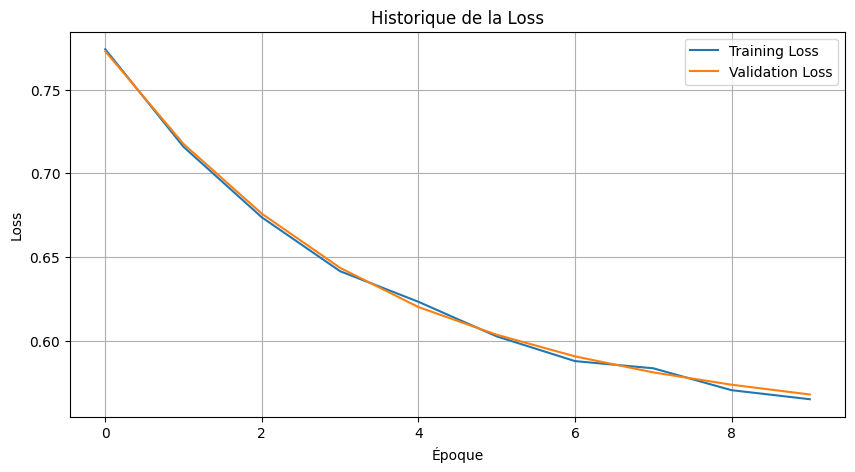

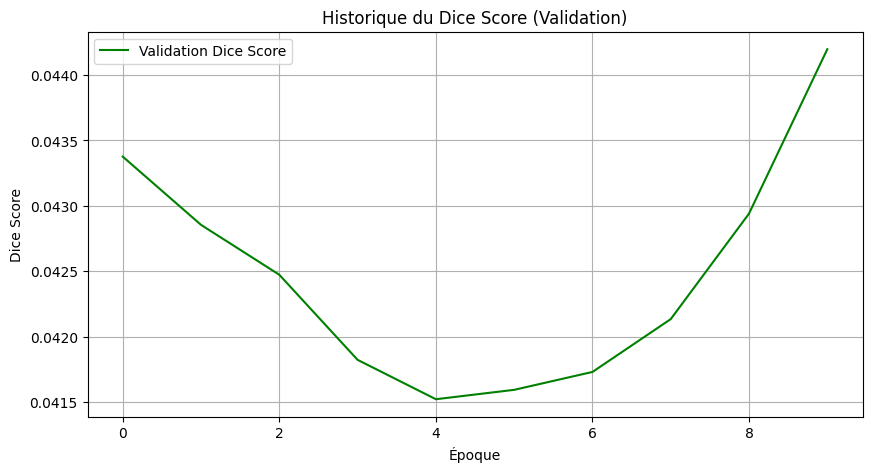

In [9]:
# Exécution de l'entraînement et de la validation
history = train_validate_model(
    model, 
    train_dataloader, 
    val_dataloader, 
    criterion, 
    optimizer, 
    DEVICE, 
    NUM_EPOCHS
)

# --- Affichage des résultats finaux ---
import matplotlib.pyplot as plt

final_train_loss = history['train_loss'][-1]
final_val_loss = history['val_loss'][-1]
final_val_dice = history['val_dice'][-1]

print("\n" + "="*50)
print("           RÉSUMÉ FINAL DE L'ENTRAÎNEMENT")
print("="*50)
print(f"Nombre d'époques : {NUM_EPOCHS}")
print(f"Loss d'Entraînement Finale : {final_train_loss:.6f}")
print(f"--------------------------------------------------")
print(f"Loss de Validation Finale  : {final_val_loss:.6f}")
print(f"Coefficient de Dice Final (Validation) : {final_val_dice:.4f} (Max: 1.0)")
print("="*50)


# --- Visualisation de l'historique ---

# Plot Loss
plt.figure(figsize=(10, 5))
plt.plot(history['train_loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Historique de la Loss')
plt.xlabel('Époque')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot Dice Score
plt.figure(figsize=(10, 5))
plt.plot(history['val_dice'], label='Validation Dice Score', color='green')
plt.title('Historique du Dice Score (Validation)')
plt.xlabel('Époque')
plt.ylabel('Dice Score')
plt.legend()
plt.grid(True)
plt.show()